# CDSE Sentinel L1C/L2A product request reporting

In [1]:
import os
import pystac_client
import pandas as pd
import folium
from datetime import datetime, timedelta

In [2]:
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
catalog = pystac_client.Client.open(ENDPOINT_STAC)

## BBOX visualization of the ROI - France

In [3]:
# Define the bbox: [min_longitude, min_latitude, max_longitude, max_latitude]
bbox = [-5.2, 41.3, 9.8, 51.2]

# Calculate the center of the bbox for the map
center_lat = (bbox[1] + bbox[3]) / 2
center_lon = (bbox[0] + bbox[2]) / 2

# Create a folium map centered at the center of the bbox
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Add a rectangle to represent the bbox
folium.Rectangle(
    bounds=[(bbox[1], bbox[0]), (bbox[3], bbox[2])],
    color='red',
    weight=2,
    fill=True,
    fill_opacity=0.2,
    tooltip='Bounding Box'
).add_to(m)

# Display the map
m


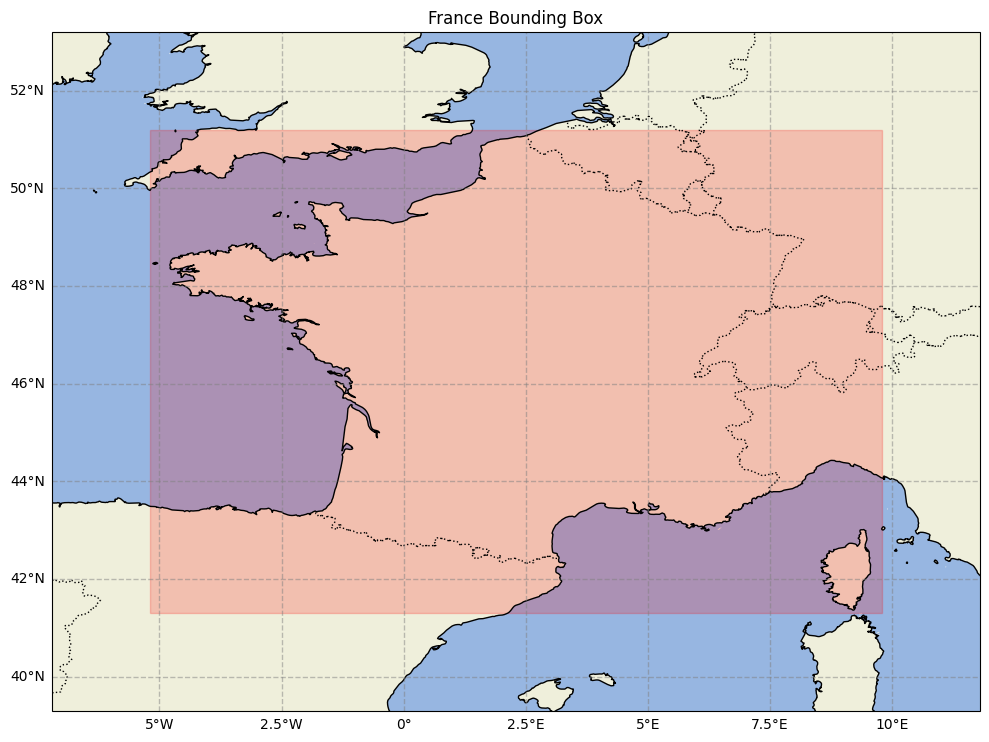

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# Define the bbox: [min_longitude, min_latitude, max_longitude, max_latitude]
bbox = [-5.2, 41.3, 9.8, 51.2]

# Create figure and axis with projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add natural earth features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add the bounding box as a rectangle
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
rect = Rectangle((bbox[0], bbox[1]), width, height,
                 edgecolor='red',
                 facecolor='red',
                 alpha=0.2,
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Set the map extent with some padding
padding = 2
ax.set_extent([bbox[0] - padding, bbox[2] + padding,
               bbox[1] - padding, bbox[3] + padding],
              crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title
plt.title('France Bounding Box')

plt.tight_layout()
plt.show()


## Perform a query to get L1C and L2A

### 2024-09-02/2024-09-07

In [5]:
bbox = [-5.2, 41.3, 9.8, 51.2]
# Search for Sentinel-2 L1C items
items_l2a = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024-09-02/2024-09-07",
    query=["eo:cloud_cover<=100"]
).item_collection()

In [6]:
# Search for Sentinel-2 L1C items
items_l1c = catalog.search(
    collections=["sentinel-2-l1c"],
    bbox = bbox,
    datetime="2024-09-02/2024-09-07",
    query=["eo:cloud_cover<=100"]
).item_collection()

In [7]:
## Analyze the request results
df_l2a = pd.DataFrame([item.to_dict() for item in items_l2a.items])
df_l1c = pd.DataFrame([item.to_dict() for item in items_l1c.items])
df_l2a = df_l2a.sort_values(by='id',ascending=False)
df_l1c = df_l1c.sort_values(by='id',ascending=False)

In [8]:
# Check product id mnatchig
def remove_last_segment_rsplit(sentinel_id):
    # Split from the right side, max 1 split
    parts = sentinel_id.rsplit('_', 1)
    return parts[0]

# Apply to dataframes to create a key for matching
df_l2a['id_key'] = df_l2a['id'].apply(remove_last_segment_rsplit)
df_l2a['id_key'] = df_l2a['id_key'].str.replace('MSIL2A_', 'MSIL1C_')
df_l1c['id_key'] = df_l1c['id'].apply(remove_last_segment_rsplit)

In [9]:
print(f"Number of L1C products {len(df_l1c)}")
print(f"Number of L2A products {len(df_l2a)}")
unique_l1c = len(df_l1c['id_key'].unique())
print(f"Number of unique L1C products: {unique_l1c}")
unique_l2a = len(df_l2a['id_key'].unique())
print(f"Number of unique L2A products: {unique_l2a}")
print(f"Diffence unique nb of product -> L2A - L1C products: {unique_l2a - unique_l1c}")

Number of L1C products 480
Number of L2A products 480
Number of unique L1C products: 458
Number of unique L2A products: 458
Diffence unique nb of product -> L2A - L1C products: 0


Number of L1C products is different that number of UNIQUE L1C products due to reprocessing (Same for the L2A)

In [10]:
# new_df_l2a = df_l2a[df_l2a['id_key'].isin(df_l1c['id_key'].unique())]

### Request over 2024-05-05/2024-05-10

In [11]:
items_l2a = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024-05-05/2024-05-10",
    query=["eo:cloud_cover<=100"]
).item_collection()

In [12]:
items_l1c = catalog.search(
    collections=["sentinel-2-l1c"],
    bbox = bbox,
    datetime="2024-05-05/2024-05-10",
    query=["eo:cloud_cover<=100"]
).item_collection()

In [13]:
df_l2a = pd.DataFrame([item.to_dict() for item in items_l2a.items])
df_l1c = pd.DataFrame([item.to_dict() for item in items_l1c.items])

# Apply to dataframes to create a key for matching
df_l2a['id_key'] = df_l2a['id'].apply(remove_last_segment_rsplit)
df_l2a['id_key'] = df_l2a['id_key'].str.replace('MSIL2A_', 'MSIL1C_')
df_l1c['id_key'] = df_l1c['id'].apply(remove_last_segment_rsplit)

print(f"Number of L1C products {len(df_l1c)}")
print(f"Number of L2A products {len(df_l2a)}")
unique_l1c = len(df_l1c['id_key'].unique())
print(f"Number of unique L1C products: {unique_l1c}")
unique_l2a = len(df_l2a['id_key'].unique())
print(f"Number of unique L2A products: {unique_l2a}")
print(f"Diffence unique nb of product -> L2A - L1C products: {unique_l2a - unique_l1c}")

Number of L1C products 457
Number of L2A products 457
Number of unique L1C products: 457
Number of unique L2A products: 457
Diffence unique nb of product -> L2A - L1C products: 0


3 Products is missing for L1C 

## BBOX visualization of the ROI - Central Europe

In [14]:
bbox = [3.2833, 45.3833, 11.2, 50.1833]

# Calculate the center of the bbox for the map
center_lat = (bbox[1] + bbox[3]) / 2
center_lon = (bbox[0] + bbox[2]) / 2

# Create a folium map centered at the center of the bbox
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Add a rectangle to represent the bbox
folium.Rectangle(
    bounds=[(bbox[1], bbox[0]), (bbox[3], bbox[2])],
    color='red',
    weight=2,
    fill=True,
    fill_opacity=0.2,
    tooltip='Bounding Box'
).add_to(m)

# Display the map
m

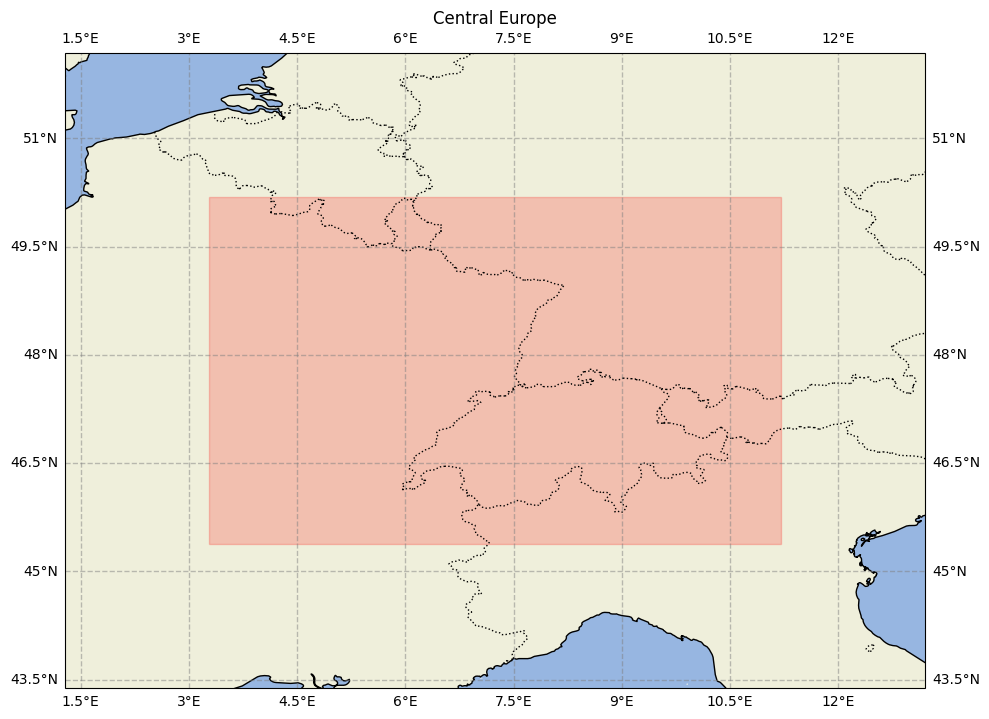

In [15]:
# Create figure and axis with projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add natural earth features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add the bounding box as a rectangle
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
rect = Rectangle((bbox[0], bbox[1]), width, height,
                 edgecolor='red',
                 facecolor='red',
                 alpha=0.2,
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Set the map extent with some padding
padding = 2
ax.set_extent([bbox[0] - padding, bbox[2] + padding,
               bbox[1] - padding, bbox[3] + padding],
              crs=ccrs.PlateCarree())
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# Add title
plt.title('Central Europe')

plt.tight_layout()
plt.show()

In [ ]:
bbox = [3.2833, 45.3833, 11.2, 50.1833]

# Define the start and end dates
start_date = datetime(2024, 11, 26)
end_date = datetime(2025, 1, 1)

# Loop through the date range with a step of 5 days
current_date = start_date
while current_date < end_date:
    # Calculate the end of the current 5-day interval
    next_date = min(current_date + timedelta(days=5), end_date)

    # Format the dates as required for the query
    date_interval = f"{current_date.strftime('%Y-%m-%d')}/{next_date.strftime('%Y-%m-%d')}"

    # Search for L2A and L1C items in the current interval
    items_l2a = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=date_interval,
        query=["eo:cloud_cover<=100"]
    ).item_collection()

    items_l1c = catalog.search(
        collections=["sentinel-2-l1c"],
        bbox=bbox,
        datetime=date_interval,
        query=["eo:cloud_cover<=100"]
    ).item_collection()
    print(f"L1C Items for {date_interval}: {len(items_l1c)}")
    print(f"L2A Items for {date_interval}: {len(items_l2a)}")
    print("####")
    current_date = next_date

L1C Items for 2024-11-26/2024-12-01: 124
L2A Items for 2024-11-26/2024-12-01: 124
####
L1C Items for 2024-12-01/2024-12-06: 86
L2A Items for 2024-12-01/2024-12-06: 86
####


### Use the ODATA API 

In [17]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Define your bounding box and date range
bbox = [3.2833, 45.3833, 11.2, 50.1833]
start_date = datetime(2024, 11, 26)
end_date = datetime(2025, 1, 1)
max_items = 1000  # Set the maximum number of items to return

# Generate the polygon string from bbox [minx, miny, maxx, maxy]
polygon = f"POLYGON (({bbox[0]} {bbox[1]}, {bbox[0]} {bbox[3]}, {bbox[2]} {bbox[3]}, {bbox[2]} {bbox[1]}, {bbox[0]} {bbox[1]}))"

# Loop through the date range with a step of 5 days
current_date = start_date
while current_date < end_date:
    # Calculate the end of the current 5-day interval
    next_date = min(current_date + timedelta(days=5), end_date)

    # Format the dates as required for the OData query (ISO format with Z for UTC)
    start_interval = f"{current_date.strftime('%Y-%m-%dT00:00:00.000Z')}"
    end_interval = f"{next_date.strftime('%Y-%m-%dT23:59:59.999Z')}"

    date_interval = f"{current_date.strftime('%Y-%m-%d')}/{next_date.strftime('%Y-%m-%d')}"

    # Search for Sentinel-2 L2A products for this interval
    l2a_json = requests.get(
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-2' and "
        f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}') and "
        f"contains(Name,'MSIL2A') and "
        f"ContentDate/Start gt {start_interval} and ContentDate/Start lt {end_interval}"
        f"&$top={max_items}"
    ).json()

    # Count L2A products
    l2a_count = len(l2a_json.get('value', []))

    # Search for Sentinel-2 L1C products for this interval
    l1c_json = requests.get(
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-2' and "
        f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}') and "
        f"contains(Name,'MSIL1C') and "
        f"ContentDate/Start gt {start_interval} and ContentDate/Start lt {end_interval}"
        f"&$top={max_items}"
    ).json()

    # Count L1C products
    l1c_count = len(l1c_json.get('value', []))

    # Print results for this interval
    print(f"L1C Items for {date_interval}: {l1c_count}")
    print(f"L2A Items for {date_interval}: {l2a_count}")
    print("####")

    # Move to the next 5-day interval
    current_date = next_date


L1C Items for 2024-11-26/2024-12-01: 124
L2A Items for 2024-11-26/2024-12-01: 124
####
L1C Items for 2024-12-01/2024-12-06: 86
L2A Items for 2024-12-01/2024-12-06: 86
####
L1C Items for 2024-12-06/2024-12-11: 144
L2A Items for 2024-12-06/2024-12-11: 144
####
L1C Items for 2024-12-11/2024-12-16: 179
L2A Items for 2024-12-11/2024-12-16: 179
####
L1C Items for 2024-12-16/2024-12-21: 165
L2A Items for 2024-12-16/2024-12-21: 165
####
L1C Items for 2024-12-21/2024-12-26: 116
L2A Items for 2024-12-21/2024-12-26: 116
####
L1C Items for 2024-12-26/2024-12-31: 116
L2A Items for 2024-12-26/2024-12-31: 116
####
L1C Items for 2024-12-31/2025-01-01: 45
L2A Items for 2024-12-31/2025-01-01: 45
####


## Missing data for a small ROI - Australia Great Barrier Reef Area 

In [18]:
bbox = [146.5, -22.0, 149.5, -20.0]

## 

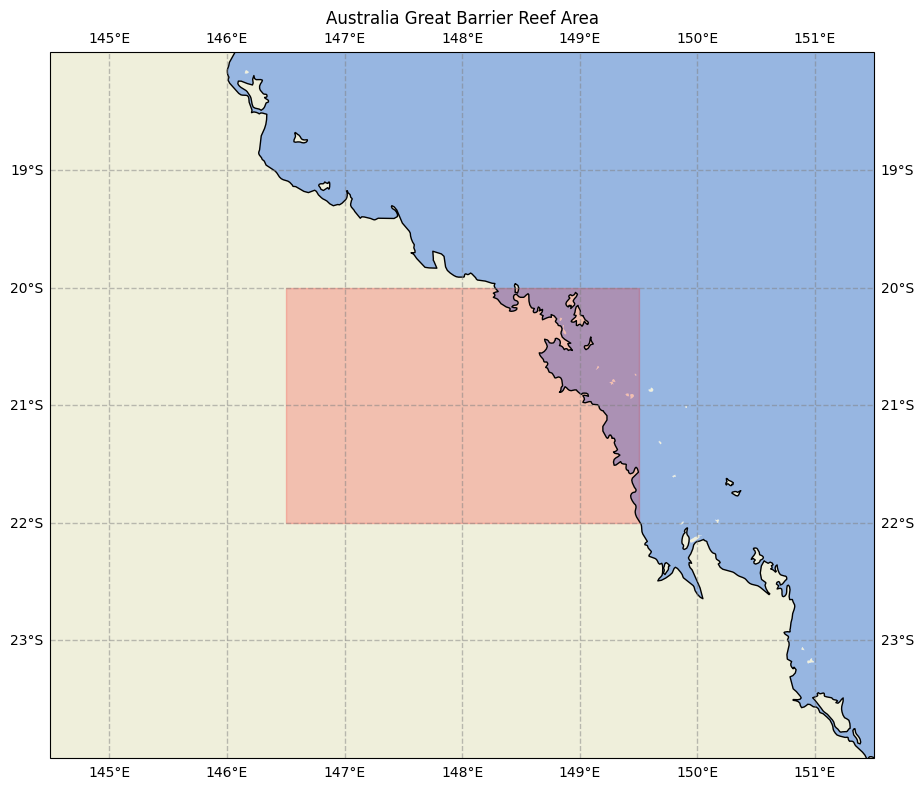

In [19]:
# Create figure and axis with projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add natural earth features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add the bounding box as a rectangle
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
rect = Rectangle((bbox[0], bbox[1]), width, height,
                 edgecolor='red',
                 facecolor='red',
                 alpha=0.2,
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)
# Set the map extent with some padding
padding = 2
ax.set_extent([bbox[0] - padding, bbox[2] + padding,
               bbox[1] - padding, bbox[3] + padding],
              crs=ccrs.PlateCarree())
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Add title
plt.title('Australia Great Barrier Reef Area')

plt.tight_layout()
plt.show()

In [20]:
items_l2a = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2022-07-19/2022-07-24",
    max_items=1000,
    query=["eo:cloud_cover<=100"]
).item_collection()
# Search for Sentinel-2 L1C items
items_l1c = catalog.search(
    collections=["sentinel-2-l1c"],
    bbox = bbox,
    datetime="2022-07-19/2022-07-24",
    max_items=1000,
    query=["eo:cloud_cover<=10"]
).item_collection()

In [21]:
df_l2a = pd.DataFrame([item.to_dict() for item in items_l2a.items])
df_l1c = pd.DataFrame([item.to_dict() for item in items_l1c.items])

In [22]:
print(f"Number of L1C products {len(df_l1c)}")
print(f"Number of L2A products {len(df_l2a)}")

Number of L1C products 0
Number of L2A products 30


In [ ]:
import requests
import pandas as pd

# Define the bounding box
bbox = [146.5, -22.0, 149.5, -20.0]
start_date = "2022-07-19T00:00:00.000Z"  # Added Z for proper OData datetime format
end_date = "2022-07-24T23:59:59.999Z"    # Added Z for proper OData datetime format

# SAME Result with this format
# start_date = "2022-07-19"
# end_date = "2022-07-24"

max_items = 1000  # Set the maximum number of items to return
max_cloud_cover = 100  # Set maximum cloud coverage to 5%

# Generate the polygon string from bbox [minx, miny, maxx, maxy]
polygon = f"POLYGON (({bbox[0]} {bbox[1]}, {bbox[0]} {bbox[3]}, {bbox[2]} {bbox[3]}, {bbox[2]} {bbox[1]}, {bbox[0]} {bbox[1]}))"

# Search for Sentinel-2 L2A products with cloud coverage filter
l2a_json = requests.get(
    f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-2' and "
    f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}') and "
    f"contains(Name,'MSIL2A') and "
    f"ContentDate/Start gt {start_date} and ContentDate/Start lt {end_date} and "
    f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le {max_cloud_cover})"
    f"&$count=True"
    f"&$top={max_items}"
).json()

# Create dataframe for L2A products
df_l2a = pd.DataFrame.from_dict(l2a_json['value'])

# Search for Sentinel-2 L1C products with cloud coverage filter
l1c_json = requests.get(
    f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-2' and "
    f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}') and "
    f"contains(Name,'MSIL1C') and "
    f"ContentDate/Start gt {start_date} and ContentDate/Start lt {end_date} and "
    f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le {max_cloud_cover})"
    f"&$top={max_items}"
).json()
# Create dataframe for L1C products
df_l1c = pd.DataFrame.from_dict(l1c_json['value'])

With STAC ->  L1C = 0 ; L2A = 30

With ODATA -> L1C = 60 ; L2A = 60

## Work Around to Befenit from Boto3 and download the Level / band I need

In [ ]:
## Set up CDSE BOTO3 API KEY
## Fill the .env with your credentials

In [36]:
from dotenv import load_dotenv
load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"

In [26]:
import boto3

class S3Connector:
    """A clean connector for S3-compatible storage services"""

    def __init__(self, endpoint_url, access_key_id,
                 secret_access_key, region_name='default'):
        """Initialize the S3Connector with connection parameters"""
        self.endpoint_url = endpoint_url
        self.access_key_id = access_key_id
        self.secret_access_key = secret_access_key
        self.region_name = region_name

        # Create session
        self.session = boto3.session.Session()

        # Initialize S3 resource
        self.s3 = self.session.resource(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

        # Initialize S3 client
        self.s3_client = self.session.client(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

    def get_s3_client(self):
        """Get the boto3 S3 client"""
        return self.s3_client

    def get_s3_resource(self):
        """Get the boto3 S3 resource"""
        return self.s3

    def get_bucket(self, bucket_name):
        """Get a specific bucket by name"""
        return self.s3.Bucket(bucket_name)

    def list_buckets(self):
        """List all available buckets"""
        response = self.s3_client.list_buckets()
        if 'Buckets' in response:
            return [bucket['Name'] for bucket in response['Buckets']]
        return []

In [27]:
catalog = pystac_client.Client.open(ENDPOINT_STAC)
connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()
print("Available buckets:", buckets)

Available buckets: ['EODATA', 'DIAS']


In [28]:
url = df_l2a['S3Path'][0]
print(url)
url = url.replace("/eodata","")
url_manifest  = f"{url}/manifest.safe"

bucket = s3.Bucket("eodata")
# Extract the filename from the path
_, filename = os.path.split(url_manifest)
bucket.download_file(url_manifest, f"{filename}")

/eodata/Sentinel-2/MSI/L2A/2022/07/19/S2B_MSIL2A_20220719T002059_N0400_R116_T55KGS_20220719T014617.SAFE


In [29]:
filename

'manifest.safe'

In [30]:
import xml.etree.ElementTree as ET
import pandas as pd

try:
    manifest_path = "./manifest.safe"

    if not os.path.exists(manifest_path):
        print(f"Error: File not found at {manifest_path}")
    else:
        # Read the file content directly
        with open(manifest_path, 'r', encoding='utf-8') as file:
            content = file.read()

        # Parse the content
        root = ET.fromstring(content)

        # Extract all elements with an href attribute using a generic approach
        hrefs = []
        for elem in root.findall(".//*[@href]"):
            href = elem.get('href')
            if href:
                hrefs.append(href)

        print(f"Found {len(hrefs)} href values in the manifest")

        # Create DataFrame and continue as before
        df_files = pd.DataFrame({
            'href': hrefs,
            'file_type': [href.split('.')[-1] if '.' in href else 'unknown' for href in hrefs],
            'file_name': [os.path.basename(href) for href in hrefs]
        })

except Exception as e:
    print(f"Error processing manifest: {str(e)}")

Found 86 href values in the manifest


In [31]:
# Filter for band files in GRANULE directory
df_gr = df_files[
     (
        df_files['href'].str.contains('_B01_') |
        df_files['href'].str.contains('_B02_') |
        df_files['href'].str.contains('_B03_') |
        df_files['href'].str.contains('_B04_') |
        df_files['href'].str.contains('_B05_') |
        df_files['href'].str.contains('_B06_') |
        df_files['href'].str.contains('_B07_') |
        df_files['href'].str.contains('_B08_') |
        df_files['href'].str.contains('_B8A_') |
        df_files['href'].str.contains('_B09_') |
        df_files['href'].str.contains('_B10_') |
        df_files['href'].str.contains('_B11_') |
        df_files['href'].str.contains('_B12_') |
        df_files['href'].str.contains('_TCI_')
    )
]
# Display the count of filtered files
print(f"Found {len(df_gr)} band files in GRANULE directory")


Found 28 band files in GRANULE directory


In [32]:
df_gr['href'] = df_gr['href'].str.replace(r'^\./', '', regex=True)

df_gr

/tmp/ipykernel_759174/2515646904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gr['href'] = df_gr['href'].str.replace(r'^\./', '', regex=True)


,href,file_type,file_name
13,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B02_10m.jp2
14,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B03_10m.jp2
15,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B04_10m.jp2
16,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B08_10m.jp2
17,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_TCI_10m.jp2
20,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B01_20m.jp2
21,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B02_20m.jp2
22,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B03_20m.jp2
23,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B04_20m.jp2
24,GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG...,jp2,T55KGS_20220719T002059_B05_20m.jp2


In [33]:
for gr in df_gr['href']:

    s3_url = f"{url}/{gr}"
    print(s3_url)
    # Extract the filename from the path
    _, filename = os.path.split(s3_url)
    bucket.download_file(s3_url, f"{filename}")

/Sentinel-2/MSI/L2A/2022/07/19/S2B_MSIL2A_20220719T002059_N0400_R116_T55KGS_20220719T014617.SAFE/GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG_DATA/R10m/T55KGS_20220719T002059_B02_10m.jp2
/Sentinel-2/MSI/L2A/2022/07/19/S2B_MSIL2A_20220719T002059_N0400_R116_T55KGS_20220719T014617.SAFE/GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG_DATA/R10m/T55KGS_20220719T002059_B03_10m.jp2
/Sentinel-2/MSI/L2A/2022/07/19/S2B_MSIL2A_20220719T002059_N0400_R116_T55KGS_20220719T014617.SAFE/GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG_DATA/R10m/T55KGS_20220719T002059_B04_10m.jp2
/Sentinel-2/MSI/L2A/2022/07/19/S2B_MSIL2A_20220719T002059_N0400_R116_T55KGS_20220719T014617.SAFE/GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG_DATA/R10m/T55KGS_20220719T002059_B08_10m.jp2
/Sentinel-2/MSI/L2A/2022/07/19/S2B_MSIL2A_20220719T002059_N0400_R116_T55KGS_20220719T014617.SAFE/GRANULE/L2A_T55KGS_A028027_20220719T002059/IMG_DATA/R10m/T55KGS_20220719T002059_TCI_10m.jp2
/Sentinel-2/MSI/L2A/2022/07/19/S2B_MSIL2A_20220719T0020

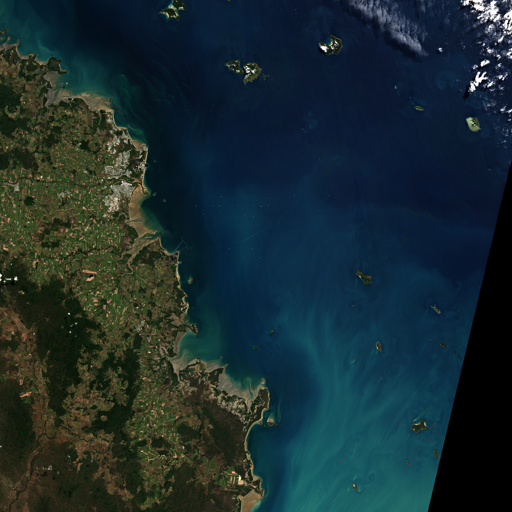

In [34]:
from PIL import Image

image = Image.open("T55KGS_20220719T002059_TCI_60m.jp2")
resized_image = image.resize((512, 512))
resized_image

In [35]:
### CDSE only accept MultiLineString and not Bounding Box

import geopandas as gpd
from shapely.geometry import MultiLineString, LineString
import json

# Define the bbox: [min_longitude, min_latitude, max_longitude, max_latitude]
bbox = [146.5, -22.0, 149.5, -20.0]

# Create four separate line segments
bottom_edge = LineString([(bbox[0], bbox[1]), (bbox[2], bbox[1])])  # Bottom edge
right_edge = LineString([(bbox[2], bbox[1]), (bbox[2], bbox[3])])   # Right edge
top_edge = LineString([(bbox[2], bbox[3]), (bbox[0], bbox[3])])     # Top edge
left_edge = LineString([(bbox[0], bbox[3]), (bbox[0], bbox[1])])    # Left edge

# Create MultiLineString geometry
multi_line = MultiLineString([bottom_edge, right_edge, top_edge, left_edge])

# Also save as GeoJSON
geojson = {
   "type": "MultiLineString",
   "bbox": bbox,
   "coordinates": [
      [
         [bbox[0], bbox[1]],  # Bottom edge
         [bbox[2], bbox[1]]
      ],
      [
         [bbox[2], bbox[1]],  # Right edge
         [bbox[2], bbox[3]]
      ],
      [
         [bbox[2], bbox[3]],  # Top edge
         [bbox[0], bbox[3]]
      ],
      [
         [bbox[0], bbox[3]],  # Left edge
         [bbox[0], bbox[1]]
      ]
   ]
}

with open("australia_bbox_multilinestring.geojson", "w") as f:
    json.dump(geojson, f, indent=3)

print("MultiLineString GeoJSON created successfully!")

MultiLineString GeoJSON created successfully!
